# Notebook settings
This notebook is a universal frame for training the DB-FBHCN model. It can take in any Parquet dataset with suitable configuration.

In [44]:
### Dataset configuration
# The parquet folder. It should be located inside datasets/.
DATASET_NAME   = 'Electronics.parquet'
# The input text column
TEXT_COL_NAME  = 'title'
# Which column to use as labelled classes. It should be a column of lists of strings.
CLASS_COL_NAME = 'category'
# How many hierarchical levels to work on. Note that the dataset must also have at least this many levels for every example.
DEPTH = 2 

### Checkpoint configuration
# Whether to train from scratch or to load a checkpoint
TRAIN_FROM_SCRATCH=False
# Checkpoint iteration to load if not training from scratch
LOAD_ITERATION=0
# Last or best results from that iteration?
LOAD_BEST=True

### System configuration
# Will try to use your NVIDIA GPU if one is available. Set to False to force CPU computation
PREFER_GPU         = True
# If you don't have the huggingface transformers library installed, flip this to True.
# You only need to do this once. Once DistilBERT has been downloaded, it will be cached in your system's default user cache folder.
# Once it is cached, please set this to False to avoid redownloads.
INSTALL_DISTILBERT = False

# Import common libraries
And also set up a few things.

In [3]:
import dask.dataframe as dd
import numpy as np
import torch
from tqdm.notebook import tqdm
import numpy as np
import shutil, sys
from sklearn import metrics
import os

# Set up GPU if available
device = 'cuda' if torch.cuda.is_available() and PREFER_GPU else 'cpu'
print('Using', device)

Using cuda


# Import data

In [4]:
data = dd.read_parquet('../../datasets/{}'.format(DATASET_NAME))
data.head(10)

,category,title,description,brand,feature
index,,,,,
0,"[Camera & Photo, Video Surveillance, Surveilla...",Genuine Geovision 1 Channel 3rd Party NVR IP S...,The following camera brands and models have be...,GeoVision,"[Genuine Geovision 1 Channel NVR IP Software, ..."
1,"[eBook Readers & Accessories, eBook Readers]",One Hot Summer,A zesty tale. (Publishers Weekly)<br /><br />G...,Visit Amazon's Carolina Garcia Aguilera Page,[]
2,"[eBook Readers & Accessories, eBook Readers]",sex.lies.murder.fame.: A Novel,“sex.lies.murder.fame. is brillllli—f@#*ing—an...,Visit Amazon's Lolita Files Page,[]
3,"[eBook Readers & Accessories, eBook Readers]",Girl with a One-track Mind: Confessions of the...,GIRL WITH A ONE-TRACK MIND: CONFESSIONS OF THE...,ABBY LEE,[]
4,"[eBook Readers & Accessories, eBook Readers]",The Last Life: A Novel,Claire Messud's piercing second novel asks que...,Visit Amazon's Claire Messud Page,[]
5,"[eBook Readers & Accessories, eBook Readers]",Lady Lazarus,"In this gleeful, difficult debut, Altschul lay...",Visit Amazon's Andrew Foster Altschul Page,[]
6,"[Computers & Accessories, Computer Accessories...",SAMSUNG Evo Plus 64 GB MicroSDXC Class 10 80 M...,"Brand SAMSUNG Speed 80 MB/s Read Speed, 20 Wri...",Samsung,[64 GB MicroSDHC Memory Card Class 10 Memory C...
7,"[Camera & Photo, Accessories, Blank Video Media]",TDK Hi8 MP120 Premium Performance Camcorder Vi...,TDK Hi8 MP120 Premium Performance Camcorder Vi...,TDK Electronics Corp,[]
8,"[eBook Readers & Accessories, eBook Readers]",The Angel Doll: A Christmas Story,"YA?Life in Thomasville, NC, in the 1950s is no...",Visit Amazon's Jerry Bledsoe Page,[]


# Categorical-encode the classes
DB-FBHCN uses a different indexing scheme compared to C-HMCNN and HMCN-F.

The first step would be to separate each level into their own column. Then, for categorical encoding to work, the columns themselves must be in Dask's `category` datatype, instead of the default `object` type for non-numerical columns.

For DB-FBHCN, we directly use the codes instead of binarising them.

In [5]:
def preprocess_classes(data, original_name, depth, verbose=False):
    """
    Build a list of unique class names for each level and create bidirectional mappings.
    """
    cls2idx = []
    idx2cls = []
    for i in range(depth): 
        category_li = data[original_name].apply(
            lambda lst: lst[i], meta=(original_name, 'object')
        ).astype('category').cat.as_known()
        if verbose:
            print(category_li.cat.classes)
        cls2idx.append(dict([
            (category, index) 
            for (index, category) 
            in enumerate(category_li.cat.categories)
        ]))
        idx2cls.append(list(category_li.cat.categories))
    return cls2idx, idx2cls

cls2idx, idx2cls = preprocess_classes(data, CLASS_COL_NAME, DEPTH)    
print(cls2idx)
print('\n')
print(idx2cls)

[{'Accessories & Supplies': 0, 'Camera & Photo': 1, 'Car & Vehicle Electronics': 2, 'Computers & Accessories': 3, 'GPS, Finders & Accessories': 4, 'Headphones': 5, 'Home Audio': 6, 'Portable Audio & Video': 7, 'Security & Surveillance': 8, 'Service Plans': 9, 'Television & Video': 10, 'Wearable Technology': 11, 'eBook Readers & Accessories': 12, 'Accessories': 13}, {'AV Receivers & Amplifiers': 0, 'Accessories': 1, 'Analog-to-Digital (DTV) Converters': 2, 'Armbands': 3, 'Audio & Video Accessories': 4, 'Aviation Electronics': 5, 'Bags & Cases': 6, 'Barking-Dog Alarms': 7, 'Batteries & Battery Packs': 8, 'Batteries, Chargers & Accessories': 9, 'Binoculars & Scopes': 10, 'Biometrics': 11, 'Blank Media': 12, 'Blu-ray Players & Recorders': 13, 'Bluetooth & FM Transmitters': 14, 'Boomboxes': 15, 'Bundles': 16, 'CB & Two-Way Radios': 17, 'Cables': 18, 'Car Electronics': 19, 'Cases': 20, 'Cassette Player Adapters': 21, 'Cassette Players & Recorders': 22, 'Chargers & Power Adapters': 23, 'Clips

In [6]:
def class_to_index(data, original_name, cls2idx, depth):
    data['codes'] = data[original_name].apply(
        lambda lst: [
            cls2idx[i][cat] 
            for (i, cat) 
            in enumerate(lst[:depth])
        ],
        meta=(original_name, 'object')
    ).astype('object')

class_to_index(data, CLASS_COL_NAME, cls2idx, DEPTH)
data.head(10)

,category,title,description,brand,feature,codes
index,,,,,,
0,"[Camera & Photo, Video Surveillance, Surveilla...",Genuine Geovision 1 Channel 3rd Party NVR IP S...,The following camera brands and models have be...,GeoVision,"[Genuine Geovision 1 Channel NVR IP Software, ...","[1, 102]"
1,"[eBook Readers & Accessories, eBook Readers]",One Hot Summer,A zesty tale. (Publishers Weekly)<br /><br />G...,Visit Amazon's Carolina Garcia Aguilera Page,[],"[12, 105]"
2,"[eBook Readers & Accessories, eBook Readers]",sex.lies.murder.fame.: A Novel,“sex.lies.murder.fame. is brillllli—f@#*ing—an...,Visit Amazon's Lolita Files Page,[],"[12, 105]"
3,"[eBook Readers & Accessories, eBook Readers]",Girl with a One-track Mind: Confessions of the...,GIRL WITH A ONE-TRACK MIND: CONFESSIONS OF THE...,ABBY LEE,[],"[12, 105]"
4,"[eBook Readers & Accessories, eBook Readers]",The Last Life: A Novel,Claire Messud's piercing second novel asks que...,Visit Amazon's Claire Messud Page,[],"[12, 105]"
5,"[eBook Readers & Accessories, eBook Readers]",Lady Lazarus,"In this gleeful, difficult debut, Altschul lay...",Visit Amazon's Andrew Foster Altschul Page,[],"[12, 105]"
6,"[Computers & Accessories, Computer Accessories...",SAMSUNG Evo Plus 64 GB MicroSDXC Class 10 80 M...,"Brand SAMSUNG Speed 80 MB/s Read Speed, 20 Wri...",Samsung,[64 GB MicroSDHC Memory Card Class 10 Memory C...,"[3, 26]"
7,"[Camera & Photo, Accessories, Blank Video Media]",TDK Hi8 MP120 Premium Performance Camcorder Vi...,TDK Hi8 MP120 Premium Performance Camcorder Vi...,TDK Electronics Corp,[],"[1, 1]"
8,"[eBook Readers & Accessories, eBook Readers]",The Angel Doll: A Christmas Story,"YA?Life in Thomasville, NC, in the 1950s is no...",Visit Amazon's Jerry Bledsoe Page,[],"[12, 105]"


We can try recovering category names from this encoding to ensure consistency:

In [7]:
def retrieve_classes(codes, idx2cls):
    return [ idx2cls[i][code] for (i, code) in enumerate(codes) ]

print('Original:', data.loc[3].compute()['category'][0:DEPTH])

print('Retrieved:', retrieve_classes(data['codes'].loc[3].compute().iloc[0], idx2cls))

Original: index
3    [eBook Readers & Accessories, eBook Readers]
Name: category, dtype: object
Retrieved: ['eBook Readers & Accessories', 'eBook Readers']


# Hierarchy generation
DB-FBHCN's hierarchy is implemented as a simple array of parent class codes in their respective levels (top-level classes have themselves as their own parents - explained in the paper).

In [8]:
# TODO: Bring the above code into this thing's constructor entirely.
from functools import reduce
class PerLevelHierarchy:
    # level_sizes is a list of (distinct) class counts per hierarchical level.
    #   Its length dictates the maximum hierarchy construction depth.
    #   (that is, our above code)
    # classes is the list of distinct classes, in the order we have assembled.
    def __init__(self, data, cls2idx):
        self.levels = [ len(d.keys()) for d in cls2idx ] # TODO: Rename to level_sizes
        self.classes = reduce(lambda acc, elem: acc + elem, [ list(d.keys()) for d in cls2idx ], [])
        # Where each level starts in a global n-hot category vector
        # Its last element is coincidentally the length, which also allows us
        # to simplify the slicing code by blindly doing [offset[i] : offset[i+1]]
        self.level_offsets = reduce(lambda acc, elem: acc + [acc[len(acc) - 1] + elem], self.levels, [0])
        # Use -1 to indicate 'undiscovered'
        self.parent_of = [-1] * len(self.classes)
        for lst in data['codes']:
            # First-level classes' parent is root, but here we set them to themselves.
            # This effectively zeroes out the hierarchical loss for this level.
            self.parent_of[lst[0]] = lst[0]
            for i in range(1, len(self.levels)):
                child_idx = lst[i] + self.level_offsets[i]
                parent_idx = lst[i-1] + self.level_offsets[i - 1]
                if self.parent_of[child_idx] == -1:
                    self.parent_of[child_idx] = parent_idx

In [28]:
hierarchy = PerLevelHierarchy(data, cls2idx)
hierarchy.parent_of

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 10,
 1,
 10,
 7,
 0,
 2,
 1,
 8,
 7,
 0,
 1,
 8,
 0,
 10,
 7,
 7,
 12,
 7,
 0,
 2,
 7,
 7,
 7,
 7,
 11,
 6,
 3,
 3,
 3,
 0,
 12,
 10,
 0,
 10,
 3,
 1,
 7,
 5,
 9,
 1,
 1,
 5,
 4,
 4,
 10,
 8,
 6,
 10,
 8,
 3,
 1,
 1,
 2,
 7,
 7,
 3,
 8,
 0,
 3,
 0,
 5,
 5,
 7,
 7,
 7,
 7,
 12,
 12,
 0,
 1,
 10,
 1,
 8,
 7,
 12,
 7,
 10,
 12,
 8,
 3,
 12,
 7,
 12,
 11,
 6,
 4,
 12,
 6,
 10,
 8,
 10,
 3,
 3,
 0,
 10,
 1,
 6,
 1,
 2,
 4,
 1,
 10,
 1,
 3,
 6,
 12,
 1,
 2,
 6,
 6,
 13,
 11,
 2,
 3,
 3,
 3,
 4,
 3,
 10,
 3,
 1,
 11,
 3,
 11,
 1,
 10]

# Data and model preparation

## Installing DistilBERT
Alternative to full-fat BERT, roughly matching its performance while being faster.

In [11]:
if not INSTALL_DISTILBERT:
    os.environ['TRANSFORMERS_OFFLINE'] = '1'
else:
    !pip install transformers
    
import transformers as ppb
tokenizer = ppb.DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
base_encoder = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')
base_encoder_state = base_encoder.state_dict()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Checkpoints

In [39]:
def load_checkpoint(checkpoint_fpath, model):
    """
    checkpoint_fpath: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    
    encoder, classifier = model
    
    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    classifier.load_state_dict(checkpoint['classifier_state_dict'])
    encoder.load_state_dict(checkpoint['encoder_state_dict'])

    # return model, optimizer, epoch value, min validation loss 
    return (encoder, classifier)

def save_checkpoint(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """

    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model (min validation lost)
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

## Metrics
We define hierarchical accuracy as simply the averaged accuracy over each level. Same for precision.
In addition to those, at the end of the testing phase we'll also compute the average area under the precision-recall curve (AU(PRC)).

In [13]:
def get_metrics(local_outputs, targets):
    level_codes = [
        np.argmax(local_outputs[level], axis=1) 
        for level in range(len(local_outputs)) 
    ]
    
    accuracies = [ metrics.accuracy_score(level_codes[level], targets[:, level]) for level in range(len(hierarchy.levels)) ]
    precisions = [ metrics.precision_score(level_codes[level], targets[:, level], average='weighted') for level in range(len(local_outputs)) ]
    
    print('Leaf level:')
    print("Accuracy:", accuracies[-1])
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:", precisions[-1])
    
    global_accuracy = sum(accuracies)/len(accuracies)
    global_precision = sum(precisions)/len(precisions)
    
    print('Global level:')
    print("Accuracy:", global_accuracy)
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:", global_precision)
    
    return np.array([accuracies[-1], precisions[-1], global_accuracy, global_precision])

## Define our dataset adapter class
This wraps around our data and provides a PyTorch-compatible interface.

One point of interest is how we do not explicitly store per-level one-hot encodings. Here we simply store one global copy (n-hot-encoded) then slice from it when requested, saving a bit of memory.

In [14]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, df, hierarchy, tokenizer, max_len, text_col_name = TEXT_COL_NAME):
    self.tokenizer = tokenizer
    self.text = df[text_col_name]
    # Level sizes
    self.levels = hierarchy.levels
    self.labels = df.codes
    self.level_offsets = hierarchy.level_offsets
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, index):
    text = str(self.text.iloc[index])
    text = " ".join(text.split())
    inputs = self.tokenizer(
      text,
      None, # No text_pair
      add_special_tokens=True, # CLS, SEP
      max_length=self.max_len, # For us it's a hyperparam. See next cells.
      padding='max_length',
      truncation=True
      # BERT tokenisers return attention masks by default
    )

    labels = torch.tensor(self.labels.loc[index], dtype=torch.long)

    result = {
      'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
      'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
      'labels': labels,
    }

    return result

Regarding that `max_len` hyperparameter, let's see the string lengths' distribution:

/usr/lib/python3.9/site-packages/dask/dataframe/core.py:3718: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('title', 'int64'))

  warnings.warn(meta_warning(meta))


<AxesSubplot:>

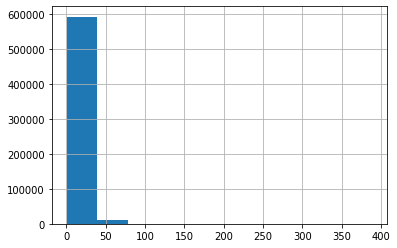

In [16]:
data[TEXT_COL_NAME].apply(lambda s: len(s.split())).compute().hist()

We prefer `max_len` to be a power of two that covers most of the strings. Here it seems 32 will do.

In [35]:
###
### TUNING HYPERPARAMETERS?
### Simply adjust here then run this cell and those below it. No need to run those above.
###

folder_name = 'checkpoints-' + DATASET_NAME
!mkdir $folder_name
CHECKPOINT_IDX = len(os.listdir(folder_name)) // 2
CHECKPOINT_PATH = './{}/{}_current.pt'.format(folder_name, CHECKPOINT_IDX)
BEST_CHECKPOINT_PATH = './{}/{}_best.pt'.format(folder_name, CHECKPOINT_IDX)

config = {
    'encoder_lr': 3e-05,
    'cls_lr': 6e-03,
    'lambda_l': 1.0,
    'lambda_h': 0.7,
    'epochs': 5,
    'dropout': 0.3,
    'hidden_nonlinear': 'relu'
}

### Don't change these if you need to compare with published results
MAX_LEN = 64
TRAIN_MINIBATCH_SIZE = 64
VAL_TEST_MINIBATCH_SIZE = 64
TRAIN_SET_RATIO = 0.8
VAL_SET_RATIO = 0.1
# The rest is test set
RANDOM_SEED = 123
# Flip to False for faster hyperparameter tuning. If False, only 5% of the full dataset is used. 
FULL_SET = False

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
mkdir: cannot create directory ‘checkpoints-Electronics.parquet’: File exists


CV-split our dataset:

In [20]:
small_data = None
if not FULL_SET:
    small_data = data.sample(frac = 0.05, random_state=RANDOM_SEED)

train_set = None
test_set = None

COLUMNS = [TEXT_COL_NAME, 'codes']

filtered = None
if FULL_SET:
    filtered = data[COLUMNS].compute()
else:
    filtered = small_data[COLUMNS].compute()

train_set = filtered.sample(frac = TRAIN_SET_RATIO, random_state=RANDOM_SEED)
val_test_set = filtered.drop(train_set.index)

val_set = val_test_set.sample(frac = VAL_SET_RATIO / (1-TRAIN_SET_RATIO), random_state=RANDOM_SEED)
test_set = val_test_set.drop(val_set.index)

train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(24080, 2)
(3010, 2)
(3010, 2)


We can now wrap them in our Datasets, and then into PyTorch's DataLoaders.

In [21]:
train_set_wrapped = CustomDataset(train_set, hierarchy, tokenizer, MAX_LEN)
val_set_wrapped = CustomDataset(val_set, hierarchy, tokenizer, MAX_LEN)
test_set_wrapped = CustomDataset(test_set, hierarchy, tokenizer, MAX_LEN)

train_loader = torch.utils.data.DataLoader(dataset=train_set_wrapped, batch_size=TRAIN_MINIBATCH_SIZE, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset=val_set_wrapped, batch_size=VAL_TEST_MINIBATCH_SIZE, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=test_set_wrapped, batch_size=VAL_TEST_MINIBATCH_SIZE, shuffle=True, num_workers=0)

Let's try retrieving the labels from the dataloader:

In [22]:
test_batch = next(iter(test_loader))
test_batch

{'ids': tensor([[  101,  1016, 18259,  ...,     0,     0,     0],
         [  101,  4521, 11039,  ...,     0,     0,     0],
         [  101, 15419,  2483,  ...,     0,     0,     0],
         ...,
         [  101,  5783,  3449,  ...,     0,     0,     0],
         [  101,  1046, 11020,  ...,     0,     0,     0],
         [  101, 11721, 27512,  ...,     0,     0,     0]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([[ 3, 27],
         [ 3, 28],
         [ 1,  1],
         [ 0,  4],
         [ 3, 28],
         [ 3, 28],
         [ 7, 17],
         [ 0,  4],
         [ 1,  1],
         [ 3, 91],
         [ 3, 49],
         [ 0,  4],
         [ 3, 91],
         [ 7, 20],
         [ 8, 45],
         [ 1,  1],
         [ 4, 42],
         [ 0,  4],
         [ 3, 49],
         [ 3, 91],

## Prepare the model itself
Here we use DistilBERT as the encoding layers, followed by our FBHCN model.

### DB-FBHCN
This is the first iteration of our novel model.

The idea is simple: one layer per hierarchical level. First layer takes in 768 BERT features (we might want to pool it later) and output $h_1$ values corresponding to scores for all categories at the first level. The second layer takes in this prediction, plus 768 original BERT features, and output $h_2$ values corresponding to scores for all categories on the second level, and so on.

The final hierarchical prediction is simply the concatenation of predictions from each level, from first to last. Each would have already been through a sigmoid function before being concatenated, but that would be done outside of the model for performance reasons.

Right now the per-level loss calculation is simply the sum of losses of each level. For this reason we make the model output each level separately. That way we can also easily argmax on each level to get the category names.

We'll also devise a novel hierarchical loss, as it is important in keeping the levels in sync.

In [32]:
import torch
from tqdm.notebook import tqdm

class DB_FBHCN(torch.nn.Module):
    def __init__(
        self, 
        input_dim, 
        hierarchy,
        config,
    ):
        super(DB_FBHCN, self).__init__()

        # Back up some parameters for use in forward()
        self.depth = len(hierarchy.levels)

        # First layer only takes in BERT encodings
        self.fc_layers = torch.nn.ModuleList([ 
            torch.nn.Linear(input_dim, hierarchy.levels[0])
        ])
        torch.nn.init.xavier_uniform_(self.fc_layers[0].weight)
        self.norms = torch.nn.ModuleList([])
        for i in range(1, depth):
            self.fc_layers.extend([ 
                torch.nn.Linear(input_dim + hierarchy.levels[i-1], hierarchy.levels[i]) 
            ])
            torch.nn.init.xavier_uniform_(self.fc_layers[i].weight)
            self.norms.extend([torch.nn.LayerNorm(hierarchy.levels[i-1], elementwise_affine=False)])
        # Activation functions
        self.hidden_nonlinear = torch.nn.ReLU() if config['hidden_nonlinear'] == 'relu' else torch.nn.Tanh()
        self.output_nonlinear = torch.nn.LogSoftmax(dim=1)

        # Dropout
        self.dropout = torch.nn.Dropout(p=config['dropout'])

    def forward(self, x):
        # We have |D| of these
        local_outputs = []
        output_l1 = self.fc_layers[0](self.dropout(x))
        local_outputs.append(self.output_nonlinear(output_l1))

        prev_output = self.hidden_nonlinear(output_l1)
        for i in range(1, self.depth):
            output_li = self.fc_layers[i](torch.cat([self.dropout(self.norms[i-1](prev_output)), x], dim=1))
            local_outputs.append(self.output_nonlinear(output_li))
            prev_output = self.hidden_nonlinear(output_li)

        return local_outputs

### Entire model

In [34]:
encoder = base_encoder
encoder.load_state_dict(base_encoder_state)
encoder.to(device)

depth = len(hierarchy.levels)
classifier = DB_FBHCN(
    768, # DistilBERT outputs 768 values.
    hierarchy,
    config
)

classifier.to(device)

DB_FBHCN(
  (fc_layers): ModuleList(
    (0): Linear(in_features=768, out_features=14, bias=True)
    (1): Linear(in_features=782, out_features=126, bias=True)
  )
  (norms): ModuleList(
    (0): LayerNorm((14,), eps=1e-05, elementwise_affine=False)
  )
  (hidden_nonlinear): ReLU()
  (output_nonlinear): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.3, inplace=False)
)

# Training time

## Training script

Now we define the loss function that we will use to fine-tune our model (DistilBERT included).

As we are performing multilabel classification here, we should use Cross Entropy Loss (the normal one for multiclass, not BCE for binary, although BCE can indeed be used for multilabel/multiclass classification). The way we use it however, is a bit different. We'll have two types of losses:
- A per-level loss, that is, $L_L = \sum_{level} NLL(y_{level}, \bar{y}_{level})$, and
- A hierarchical loss $L_H = NLL(y_{parent}, \bar{y}_{parent})$ for every level except leaf, summed up. That is, we will enforce that each level must predict the parent of whatever the next level predicted, even if they are wrong, creating a bottom-up hierarchy tracing strategy. This will be kept at a lower significance than the leaf-level loss due to its tendency to explode and knocking our gradient descent out of a good path.

The final loss is then defined as $L = \lambda_L L_L + \lambda_H L_H$ where $\lambda_H$ is likely to be smaller than $\lambda_L$.

We also construct our optimiser here, which is Adam with different learning rates for DistilBERT and our model.

All of these are put inside a `train_model` function for brevity.

In [42]:
from tqdm.notebook import tqdm

def train_model(config, training_loader, val_loader, model, hierarchy, checkpoint_path, best_checkpoint_path):
    encoder, classifier = model
    
    depth = len(hierarchy.levels)
    
    criterion = torch.nn.NLLLoss()

    optimizer = torch.optim.Adam(
        [
            {'params': encoder.parameters(), 'lr': config['encoder_lr']},
            {'params': classifier.parameters(), 'lr': config['cls_lr']}
        ], 
    )
    
    lambda_L = config['lambda_l']
    lambda_H = config['lambda_h']

    parent_of = torch.LongTensor(hierarchy.parent_of).to(device)

    val_loss_min = np.Inf
    
    # Store validation metrics after each epoch
    val_metrics = np.empty((4, 0), dtype=float)
    
    for epoch in range(1, config['epochs'] + 1):
        train_loss = 0
        # Put model into training mode. Note that this call DOES NOT train it yet.
        encoder.train()
        classifier.train()
        print('Epoch {}: Training'.format(epoch))
        for batch_idx, data in enumerate(tqdm(training_loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['labels']#.to(device, dtype = torch.long)

            features = encoder(ids, mask)[0][:,0,:]
            local_outputs = classifier(features)

            # We have two loss functions: (l)ocal (per-level), and (h)ierarchical.
            loss_l = lambda_L * sum([ criterion(
                local_outputs[level].cpu(),
                targets[:, level]
            ) for level in range(len(hierarchy.levels))])

            loss_h = lambda_H * sum([ 
                criterion(
                    local_outputs[level], 
                    torch.index_select(
                        parent_of,
                        0, 
                        torch.argmax(local_outputs[level + 1], dim=1)
                    )
                ) for level in range(depth - 1)
            ])
            loss = loss_l + loss_h

            # PyTorch defaults to accumulating gradients, but we don't need that here
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss = train_loss + (loss.item() - train_loss) / (batch_idx + 1)

        print('Epoch {}: Validating'.format(epoch))


        # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
        encoder.eval()
        classifier.eval()
        val_loss = 0

        val_targets = np.empty((0, len(hierarchy.levels)), dtype=bool)
        val_outputs = [np.empty((0, hierarchy.levels[level]), dtype=float) for level in range(len(hierarchy.levels))]

        # We're only testing here, so don't run the backward direction (no_grad).
        with torch.no_grad():
            total_loss_l = 0
            total_loss_h = 0
            for batch_idx, data in enumerate(tqdm(val_loader)):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                targets = data['labels']#.to(device, dtype = torch.long)

                features = encoder(ids, mask)[0][:,0,:]
                local_outputs = classifier(features)

                # We have two loss functions: (l)eaf, and (h)ierarchical.
#                 loss_l = lambda_L * criterion(local_outputs[depth-1], targets[:, depth-1]) 
                loss_l = sum([ criterion(
                    local_outputs[level].cpu(),
                    targets[:, level]
                ) for level in range(len(hierarchy.levels))])

                loss_h = lambda_H * sum([ 
                    criterion(
                        local_outputs[level], 
                        torch.index_select(
                            parent_of,
                            0, 
                            torch.argmax(local_outputs[level + 1], dim=1)
                        )
                    ) for level in range(depth - 1)
                ])
                loss = loss_l + loss_h
                
                total_loss_l += loss_l
                total_loss_h += loss_h

                val_loss = val_loss + (loss.item() - val_loss) / (batch_idx + 1)

                val_targets = np.concatenate([val_targets, targets.cpu().detach().numpy()])
                
                for i in range(len(val_outputs)):
                    val_outputs[i] = np.concatenate([val_outputs[i], local_outputs[i].cpu().detach().numpy()])

        # Calculate average losses
        print('Average minibatch local loss:', total_loss_l / len(val_loader))
        print('Average minibatch hierarchical loss:', total_loss_h / len(val_loader))
        


        val_metrics = np.concatenate([val_metrics, 
            np.expand_dims(
                get_metrics(val_outputs, val_targets), axis=1
            )],
            axis=1
        )
        
        train_loss = train_loss/len(training_loader)
        val_loss = val_loss/len(val_loader)
        
        # Print training/validation statistics
        print('Avgerage training loss: {:.6f}\nAverage validation loss: {:.6f}'.format( 
            train_loss,
            val_loss
        ))

        # create checkpoint variable and add important data
        checkpoint = {
            'epoch': epoch + 1,
            'val_loss_min': val_loss,
            'encoder_state_dict': encoder.state_dict(),
            'classifier_state_dict': classifier.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        best_yet = False
        if val_loss <= val_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
            # save checkpoint as best model
            best_yet = True
            val_loss_min = val_loss
        save_checkpoint(checkpoint, best_yet, checkpoint_path, best_checkpoint_path)
        print('Epoch {}: Done\n'.format(epoch))
    return (encoder, classifier), val_metrics

# Alternative: just load from disk
def run_model(model, loader, hierarchy):
    encoder, classifier = model
    # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
    encoder.eval()
    classifier.eval()

    all_targets = np.empty((0, len(hierarchy.levels)), dtype=bool)
    all_outputs = [np.empty((0, hierarchy.levels[level]), dtype=float) for level in range(len(hierarchy.levels))]

    # We're only testing here, so don't run the backward direction (no_grad).
    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['labels'].to(device, dtype = torch.long)

            features = encoder(ids, mask)[0][:,0,:]
            local_outputs = classifier(features)

            all_targets = np.concatenate([all_targets, targets.cpu().detach().numpy()])
            for i in range(len(all_outputs)):
                all_outputs[i] = np.concatenate([all_outputs[i], local_outputs[i].cpu().detach().numpy()])

    return {
        'targets': all_targets,
        'outputs': all_outputs,
    }

In [47]:
import matplotlib.pyplot as plt

trained_model = None
if TRAIN_FROM_SCRATCH:
    trained_model, val_metrics = train_model(
        config,
        train_loader,
        val_loader,
        (encoder, classifier),
        hierarchy,
        CHECKPOINT_PATH,
        BEST_CHECKPOINT_PATH
    )
    x = np.arange(config['epochs'])
    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(x, val_metrics[0], label='leaf accuracy')
    ax.plot(x, val_metrics[1], label='leaf precision')
    ax.plot(x, val_metrics[2], label='average global accuracy')
    ax.plot(x, val_metrics[3], label='average global precision')
    ax.set_xlabel('epoch')  # Add an x-label to the axes.
    ax.set_ylabel('score')  # Add a y-label to the axes.
    ax.set_title("Accuracy/precision over epochs")  # Add a title to the axes.
    ax.legend()  # Add a legend.
    fig.show()
else:
    load_path = '{}/{}_{}.pt'.format(folder_name, LOAD_ITERATION, 'best' if LOAD_BEST else 'current')
    trained_model = load_checkpoint(load_path, (encoder, classifier))

In [48]:
test_result = run_model(trained_model, test_loader, hierarchy)

  0%|          | 0/48 [00:00<?, ?it/s]

# Evaluation
We'll mainly use the leaf prediction in real-world applications to ensure 100% hierarchy matches. However, we'll still test with the global encoding just to see what we are getting.

## Metrics

In [49]:
get_metrics(test_result['outputs'], test_result['targets'])

leaf_size = hierarchy.levels[-1]
def generate_one_hot(idx):
    b = np.zeros(leaf_size, dtype=bool)
    b[idx] = 1
    return b

binarised_targets = np.array([generate_one_hot(lst[-1]) for lst in test_result['targets']])

# Rectified leaf AU(PRC) due to an sklearn bug.
# We add one artificial example that belongs to all classes at once and a corresponding prediction
# full of true positives. This way each class has at least one true positive, even if the test set
# does not contain enough examples to cover all classes.
rectified_outputs = np.concatenate([test_result['outputs'][-1], np.ones((1, leaf_size))], axis=0)
rectified_targets = np.concatenate([binarised_targets, np.ones((1, leaf_size), dtype=bool)], axis=0)

print('\n')
print('Rectified leaf-level AU(PRC) score:', metrics.average_precision_score(rectified_targets, rectified_outputs))

Leaf level:
Accuracy: 0.7647840531561462
Precision: 0.7947061688623454
Global level:
Accuracy: 0.6318936877076412
Precision: 0.6975695223502503


Rectified leaf-level AU(PRC) score: 0.8331839216885346


/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Hierarchical predictions
Let's have another visual match-up, but this time for the entire hierarchy.

In [50]:
path_codes = np.concatenate([
    np.expand_dims(
        np.argmax(test_result['outputs'][level], axis=1),
        axis=1
    ) for level in range(len(hierarchy.levels))],
    axis=1
)

path_codes

array([[ 7, 65],
       [ 0,  4],
       [ 0,  9],
       ...,
       [ 0,  4],
       [ 3, 28],
       [10, 27]])

In [54]:
predicted_classes = [retrieve_classes(row, idx2cls) for row in tqdm(path_codes)]
actual_classes = [retrieve_classes(row, idx2cls) for row in tqdm(test_result['targets'])]
import pandas as pd
comp_df = pd.DataFrame({ 'Global prediction': predicted_classes, 'Actual hierarchy': actual_classes})

  0%|          | 0/3010 [00:00<?, ?it/s]

  0%|          | 0/3010 [00:00<?, ?it/s]

In [55]:
comp_df

,Global prediction,Actual hierarchy
0,"[Portable Audio & Video, Portable Speakers & D...","[Portable Audio & Video, Portable Speakers & D..."
1,"[Accessories & Supplies, Audio & Video Accesso...","[Accessories & Supplies, Audio & Video Accesso..."
2,"[Accessories & Supplies, Batteries, Chargers &...","[Accessories & Supplies, Batteries, Chargers &..."
3,"[Camera & Photo, Office Electronics Accessories]","[Television & Video, Projection Screens]"
4,"[eBook Readers & Accessories, Covers]","[eBook Readers & Accessories, Sleeves]"
...,...,...
3005,"[Accessories & Supplies, Batteries, Chargers &...","[Accessories & Supplies, Batteries, Chargers &..."
3006,"[Accessories & Supplies, Computer Accessories ...","[Computers & Accessories, Computer Accessories..."
3007,"[Accessories & Supplies, Audio & Video Accesso...","[Computers & Accessories, Computer Accessories..."
3008,"[Computers & Accessories, Computers & Tablets]","[Computers & Accessories, Computers & Tablets]"


# Past results
2. Re-run on small set to get a hang of the current state.

```
Local leaf level accuracy:
Accuracy: 0.636986301369863
Precision: 0.6934116112198303
```

3. 0.2 bias on earlier levels. Lower hierarchical loss weight to 0.6.

```
Local leaf level accuracy:
Accuracy: 0.5753424657534246
Precision: 0.6484018264840182
```

4. 0.15 bias. Hierarchical loss back to 0.7.

```
Local leaf level accuracy:
Accuracy: 0.636986301369863
Precision: 0.7307240704500978
```

6. Full set, 0.2 bias.

```
Local leaf level accuracy:
Accuracy: 0.7784246575342466
Precision: 0.8034019785197366

versus last week:

Local 0.76883561
```

7. Back to small set. Discriminative learning rate implemented with 0.6 decay rate.

```
Local leaf level accuracy:
Accuracy: 0.6438356164383562
Precision: 0.7213796477495108
```